In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, roc_curve, RocCurveDisplay, plot_roc_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from wordcloud import WordCloud, STOPWORDS as wc_stopwords

try:
    from nltk.corpus import stopwords as nltk_stopwords
except:
    nltk.download('stopwords')
    from nltk.corpus import stopwords as nltk_stopwords

# Introduction

## Background

Looking for a job is one of the hardest parts of an adult's life. It's a long, laborius, and stressful process. Finding the job posts that suit your desire the most is not easy, let alone geting hired. Once you get an offering, sometimes it's not from your dream company. But you still need to decide whether to accept the offer, especially after you realize there isn't enough time to go to more recruitment processes.

While job hunters are competing to get a job their desire, recruiters are also competing to book their places on the job posting pages. Some recruiters are actually recruiting (seeking for someone to be employed), but some are just doing their job market research stuffs, such as collecting data from job hunters. One of the crafty and heartless methods they use is by posting fake job vacancies. 

While some fake job vacancies can be easily identified by just common sense (e.g. by reading the offered salary range and benefits), some are seemed to be blened with the real ones, even with plenty of data taken from the job post details such as company profile, requirements, and responsibilities description. 

## Goal

The main goal of this analysis is to compose a suggestion on how one should check whether a job post is fake. 

## Hypotheses 

We presume that a fake job post can be identified by inspecting its
- company profile (or simply who informs that job vacancy),
- job description,
- requirements (including whether an educational and/or working experience is required),
- benefits, 
- job title, and
- salary range.

It is possible that more the one of the variables above give important hints on helping us to identify fake job posts.

## Pre-Analysis

### Data Collection

The data is retrieved from <a href="https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction">Kaggle</a>.

In [74]:
# load the dataset
df_jobs = pd.read_csv('Datasets/fake_job_postings.csv')
df_jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Initial Exploration

In [75]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Many columns are empty, although it is expected since job posts can contain varying information.

#### 1) Company Profile

Let's assume that one unique text of company profile represents a company.  

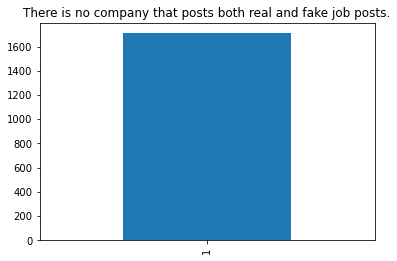

In [84]:
company_profile_fake_count = df_jobs.groupby('company_profile')['fraudulent'].nunique()
company_profile_fake_count.value_counts().plot(kind='bar')
plt.title('There is no company that posts both real and fake job posts.');

There is no any company who posts both real and fake job posts. Companies are either post real or fake job posts. It is possible that companies that only post fake job posts are not real companies, or real companies but some irresponsible individuals profiteer the companies by "borrowing" their name. But as we've written down above, there is also a chance that some real companies posts fake job vacancies intentionally.

We will validate manually some company names who post fake job posts just by googling them.

In [88]:
df_jobs[df_jobs['fraudulent'] == 1]['company_profile'].unique()[:10]

array(["\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0Staffing &amp; Recruiting done right for the Oil &amp; Energy Industry!Represented candidates are automatically granted the following perks: Expert negotiations on your behalf, maximizing your compensation package and implimenting ongoing increases\xa0Significant signing bonus by Refined Resources (in addition to any potential signing bonuses our client companies offer)1 Year access to AnyPerk: significant corporate discounts on cell phones, event tickets, house cleaning and everything inbetween. \xa0You'll save thousands on daily expenditures\xa0Professional Relocation Services for out of town candidates* All candidates are encouraged to participate in our Referral Bonus Program ranging anywhere from $500 - $1,000 for all successfully hired candidates... referred directly to t

By taking only ten samples, looks like all of them are real companies! Unfortunately, we cannot find out further whether it is the companies themselves that posted those fake job posts.

#### 2) Job Description

Text data are sometimes too crowded to analyze. As one of the simplest approach, we'll first produce two wordclouds, each from real and fake job posts description.

In [146]:
# get stopwords based on term frequencies
nltk_eng_stopwords = nltk_stopwords.words('english')
count_vectorizer = CountVectorizer(stop_words=nltk_eng_stopwords, max_df=0.05)
job_desc_count_vectorized = count_vectorizer.fit_transform(df_jobs['description'].dropna())

count_vectorizer_stopwords = list(count_vectorizer.stop_words_) + nltk_eng_stopwords

In [159]:
df_job_desc_count_vectorized = pd.DataFrame(
    data=job_desc_count_vectorized.toarray(),
    columns=list(count_vectorizer.vocabulary_.keys())
)

vocab_count = df_job_desc_count_vectorized.sum(axis=0)

<b>Fake Posts</b>

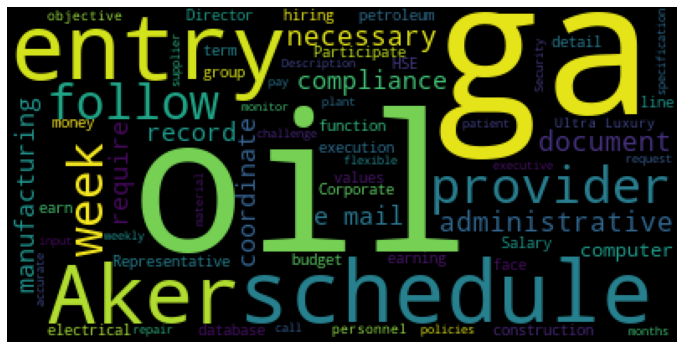

In [144]:
def draw_wordcloud(text, stopwords=wc_stopwords):
    wordcloud = WordCloud(stopwords=stopwords, random_state=22).generate(text)

    plt.figure(figsize=(12,7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# nltk_eng_stopwords = nltk_stopwords.words('english')
fake_job_desc_all = ''.join(df_jobs.query('fraudulent == 1')['description'].dropna())
draw_wordcloud(fake_job_desc_all, count_vectorizer_stopwords)

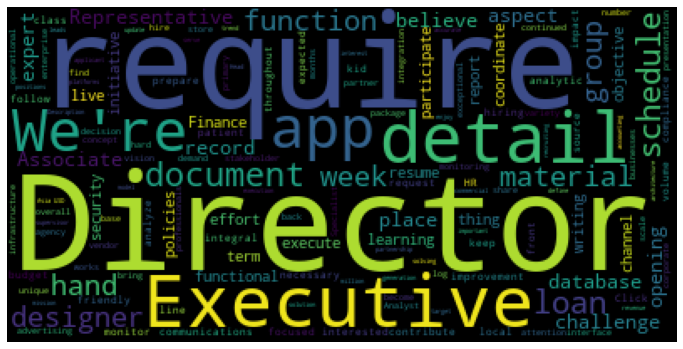

In [145]:
real_job_desc_all = ''.join(df_jobs.query('fraudulent == 0')['description'].dropna())
draw_wordcloud(real_job_desc_all, count_vectorizer_stopwords)

#### Salary

Some salary ranges contains weird text (e.g. "7-Sep", is it human error?), so we will consider them as missing values.

In [67]:
salary_with_alphabet_idx = df_jobs['salary_range'].dropna().apply(lambda x: re.search('[A-Za-z]+', x)).dropna().index
df_jobs.loc[salary_with_alphabet_idx, ['salary']] = np.nan

In [5]:
df_jobs.query('fraudulent == 0')['benefits'].unique().tolist()

[nan,
 'What you will get from usThrough being part of the 90 Seconds team you will gain:experience working on projects located around the world with an international brandexperience working with a variety of clients and on a large range of projectsopportunity to drive and grow production function and teama positive working environment with a great teamPay$40,000-$55,000Applying for this role with a VIDEOBeing a video business, we understand that one of the quickest ways that we can assess your suitability for this role, and one of the quickest ways that you can apply for it, is for you to submit a 60-90 second long video telling us about yourself, your experience and why you think you would be perfect for the role. \xa0It’s not about being a filmmaker or making a really creative video. \xa0A simple video filmed with a smart phone or web cam will be fine. Please also include where you are based and when you can start.You can upload the video onto YouTube or Vimeo (or similar) as a Draf

<AxesSubplot:xlabel='telecommuting', ylabel='count'>

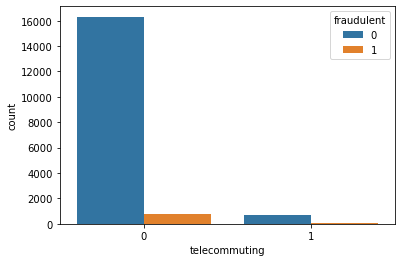

In [6]:
sns.countplot(x='telecommuting', hue='fraudulent', data=df_jobs)

In [8]:
df_jobs[
    df_jobs['description'].isin(df_jobs[df_jobs['fraudulent'] == 1]['description'].value_counts().index.tolist())
]['fraudulent'].value_counts()

1    865
0      2
Name: fraudulent, dtype: int64

In [9]:
df_jobs[
    (df_jobs['description'].isin(df_jobs[df_jobs['fraudulent'] == 1]['description'].value_counts().index.tolist()))
    & (df_jobs['fraudulent'] == 0)
]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
11889,11890,Developer (Front-end team),"GR, I, Athens",Engineering,NaN,Workable is a venture-backed startup making cl...,Workable is a product-driven software company....,"To be considered seriously, you will also have...",Our goal is to create a company where employee...,0,1,1,Full-time,Not Applicable,Bachelor's Degree,Computer Software,Engineering,0
15236,15237,Developer,"GR, I, Athens",Engineering,NaN,Workable is a venture-backed startup making cl...,Workable is a product-driven software company....,"To be considered seriously, you will also have...",Our goal is to create a company where employee...,0,1,1,Full-time,Not Applicable,Bachelor's Degree,Computer Software,Engineering,0


## Single Variable: Company Profile

In [10]:
# train test split
X = df_jobs[['company_profile']]
y = df_jobs['fraudulent'].values.reshape(-1, 1)

X.fillna(value='empty', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [11]:
# extract feature columns from company profile

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train['company_profile'])
X_test_vectorized = tfidf_vectorizer.transform(X_test['company_profile'])

oversampler = RandomOverSampler(random_state=22)
undersampler = RandomUnderSampler(random_state=22)
# X_train_ovr, y_train_ovr = oversampler.fit_resample(X_train_vectorized, y_train)
X_train_unr, y_train_unr = undersampler.fit_resample(X_train_vectorized, y_train)

In [12]:
tfidf_vectorizer.get_feature_names_out()

array(['000', '000 000', '000 active', ..., '你值得擁有的價格', 'ﬁnd', 'ﬁnd new'],
      dtype=object)

In [13]:
# model training

log_reg = LogisticRegression(random_state=22)
# log_reg.fit(X_train_vectorized, y_train.ravel())
# log_reg.fit(X_train_ovr, y_train_ovr)
log_reg.fit(X_train_unr, y_train_unr)

LogisticRegression(random_state=22)

In [14]:
# log_reg.score(X_train_vectorized, y_train)
# log_reg.score(X_train_ovr, y_train_ovr)
log_reg.score(X_train_unr, y_train_unr)

0.9011544011544012

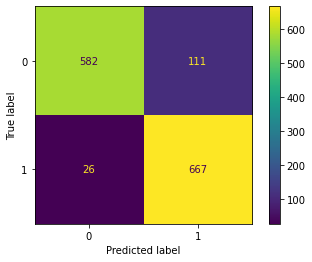

In [15]:
# plot_confusion_matrix(log_reg, X_train_vectorized, y_train)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_train_unr, log_reg.predict(X_train_unr))
).plot()

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


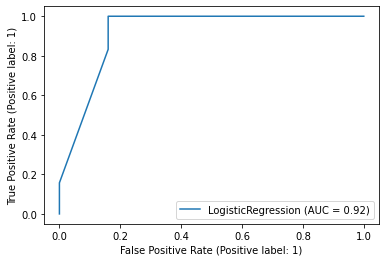

In [16]:
plot_roc_curve(log_reg, X_train_unr, y_train_unr)

In [17]:
precision_score(y_train_unr, log_reg.predict(X_train_unr))

0.8573264781491002

In [18]:
recall_score(y_train_unr, log_reg.predict(X_train_unr))

0.9624819624819625

In [19]:
log_reg.score(X_test_vectorized, y_test)

0.8400447427293065

In [20]:
precision_score(y_test, log_reg.predict(X_test_vectorized))

0.22558459422283356

In [21]:
recall_score(y_test, log_reg.predict(X_test_vectorized))

0.9479768786127167